In [1]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel("Prepared_Dataset_Scored.xlsx")
df.head(10)

,Unnamed: 0,S.No,Questions,Model Answer (ChatGPT),User Answer (Web),Actual Score (0-10),Sim_CSE Score,SBERT Score
0,0,1,List the advantages of DBMS?,1. Data Integrity: DBMS ensures data accuracy ...,1.Better Data Transferring: Database managemen...,7.0,6.666667,1.666667
1,1,2,List the database Applications?,1. MySQL 2. Oracle Database 3. Microsoft SQL S...,1.Oracle Database 2.PostgreSQL 3.SQLite 4.File...,5.0,1.818182,0.000000
2,2,3,Define instances and schemas of database?,Instance: An instance is a copy of the databas...,The overall design of the database is called d...,4.0,10.000000,7.500000
3,3,4,Discuss Data Independence?,Data independence is the ability of a system t...,Data independence is the ability to modify the...,7.0,6.666667,6.666667
4,4,5,Explain database Access for applications Programs,Database Access for applications Programs is a...,Database Access means functionality required i...,0.0,8.000000,2.000000
5,5,6,Define (i) Database (ii) DBMS,(i) Database: A database is an organized colle...,(i) A database is an organized collection of s...,6.0,10.000000,5.000000
6,6,7,Explain about Database storage structure?,Database storage structure is the way that dat...,Database storage structure is the way that dat...,10.0,10.000000,10.000000
7,7,8,Discuss Transaction management?,Transaction management is the process of manag...,A database transaction is a sequence of action...,4.0,0.000000,0.000000
8,8,9,Explain the Query Processor?,The query processor is a component of a databa...,The query processor of a database system has t...,8.0,10.000000,3.333333
9,9,10,Define (i) Entity (ii) Attribute,(i) Entity: An entity is an object or concept ...,(i) A single unique object in the real world t...,10.0,10.000000,2.500000


In [3]:
mod_ans_set = df.iloc[:, 3].values
usr_ans_set = df.iloc[:, 4].values

In [4]:
num_of_inputs = len(mod_ans_set)
hf_score = [0] * num_of_inputs

<h1 style="text-align: center">Cosine Similarity</h1>

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import norm

def cos_sim(sent1_emb, sent2_emb):
  cos = np.dot(sent1_emb, sent2_emb)/(norm(sent1_emb)*norm(sent2_emb))
  return cos

<h1 style="text-align: center">Similarity between two texts</h1>

In [6]:
from nltk.tokenize import sent_tokenize

model_hf = SentenceTransformer('sentence-transformers/paraphrase-xlm-r-multilingual-v1')

def similarity_score(text1, text2):
  mod_sent = sent_tokenize(text1)
  usr_sent = sent_tokenize(text2)
  
  mod_emb = []
  usr_emb = []

  for sent in mod_sent:
    sent_emb = model_hf.encode(sent)
    mod_emb.append(sent_emb)

  for sent in usr_sent:
    sent_emb = model_hf.encode(sent)
    usr_emb.append(sent_emb)

  n = len(mod_sent)
  m = len(usr_sent)

  sim_ans = 0

  for i in range(0, n):
    for j in range(0, m):
      if(cos_sim(mod_emb[i], usr_emb[j]) >= 0.7):
        sim_ans += 1
        break
  
  sim_ans /= n
  return sim_ans
    

<h1 style="text-align:center;">Summary of a text</h1>

In [7]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')
device = torch.device('cpu')

def summarize(text):
  preprocessed_text = text.strip().replace('\n', '')
  t5_input_text = 'summarize: ' + preprocessed_text

  tokenized_text = tokenizer.encode(t5_input_text, return_tensors='pt', max_length=512).to(device)

  summary_ids = model.generate(tokenized_text, min_length=30, max_length=120)
  summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

  return summary

c:\Users\harsh\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\t5\tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [8]:
for i in range(0, num_of_inputs):
    mod_ans = mod_ans_set[i]
    usr_ans = usr_ans_set[i]

    usr_ans += summarize(usr_ans)

    sim_val = similarity_score(mod_ans, usr_ans)

    hf_score[i] = sim_val

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [9]:
hf_score_normalized = hf_score
for i in range(0, num_of_inputs):
    hf_score_normalized[i] = hf_score[i] * 10

In [10]:
hf_score_normalized = np.array(hf_score_normalized)

df['HF_Score'] = hf_score_normalized.tolist()

In [12]:
df.head()

,Unnamed: 0,S.No,Questions,Model Answer (ChatGPT),User Answer (Web),Actual Score (0-10),Sim_CSE Score,SBERT Score,HF_Score
0,0,1,List the advantages of DBMS?,1. Data Integrity: DBMS ensures data accuracy ...,1.Better Data Transferring: Database managemen...,7.0,6.666667,1.666667,2.500000
1,1,2,List the database Applications?,1. MySQL 2. Oracle Database 3. Microsoft SQL S...,1.Oracle Database 2.PostgreSQL 3.SQLite 4.File...,5.0,1.818182,0.000000,0.000000
2,2,3,Define instances and schemas of database?,Instance: An instance is a copy of the databas...,The overall design of the database is called d...,4.0,10.000000,7.500000,5.000000
3,3,4,Discuss Data Independence?,Data independence is the ability of a system t...,Data independence is the ability to modify the...,7.0,6.666667,6.666667,3.333333
4,4,5,Explain database Access for applications Programs,Database Access for applications Programs is a...,Database Access means functionality required i...,0.0,8.000000,2.000000,4.000000


In [13]:
df.to_excel("Final_Similarity_Dataset.xlsx")

<h1 style="text-align: center;">Comparison and Evaluation</h1>

In [1]:
import pandas as pd
df = pd.read_csv("Final_Dataset.csv")
sbert_score = df['SBERT Score'].values
simcse_score = df['Sim_CSE Score'].values
hf_score = df['HF_Score'].values

In [2]:
import matplotlib.pyplot as plt

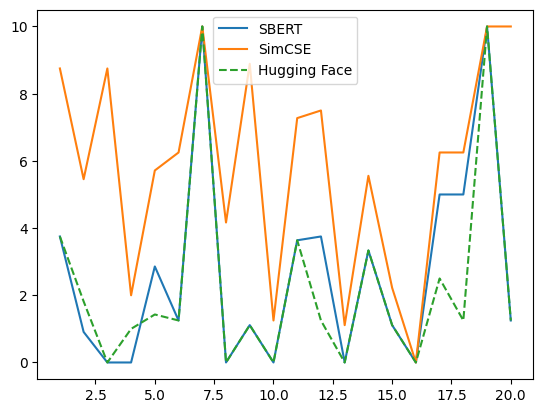

In [4]:
# Score Spanning
import numpy as np
x = np.arange(1, 21)

plt.plot(x, sbert_score[0: 20], label="SBERT")
plt.plot(x, simcse_score[0: 20], label = "SimCSE")
plt.plot(x, hf_score[0: 20], label="Hugging Face", linestyle="--")
plt.legend()
plt.show()

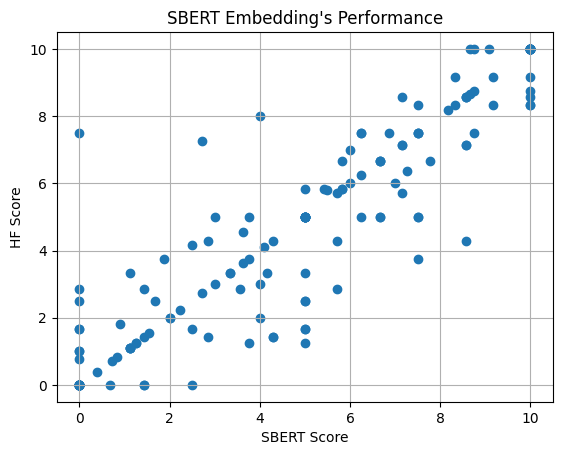

In [5]:
#Scatter Plot
plt.scatter(sbert_score, hf_score)
plt.xlabel('SBERT Score')
plt.ylabel('HF Score')
plt.grid()
plt.title("SBERT Embedding's Performance")
plt.show()

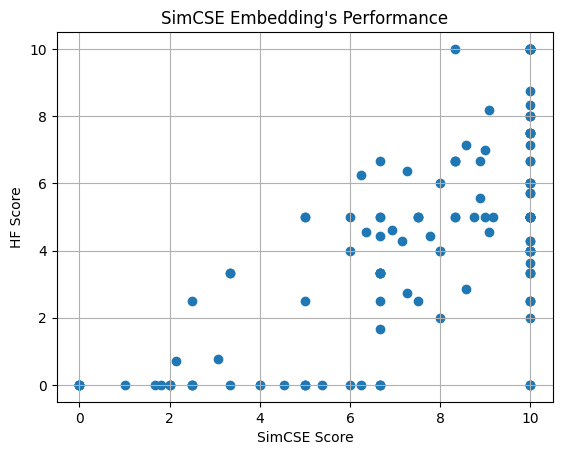

In [35]:
plt.scatter(simcse_score, hf_score)
plt.xlabel('SimCSE Score')
plt.ylabel('HF Score')
plt.grid()
plt.title("SimCSE Embedding's Performance")
plt.show()

In [6]:
# Frequency Bar Plot
sbert_freq = [0]*11
simcse_freq = [0]*11
hf_freq = [0]*11

marks = np.arange(0, 11)

for i in sbert_score:
  sbert_freq[int(i)] += 1
  
for i in simcse_score:
  simcse_freq[int(i)] += 1

for i in hf_score:
  hf_freq[int(i)] += 1


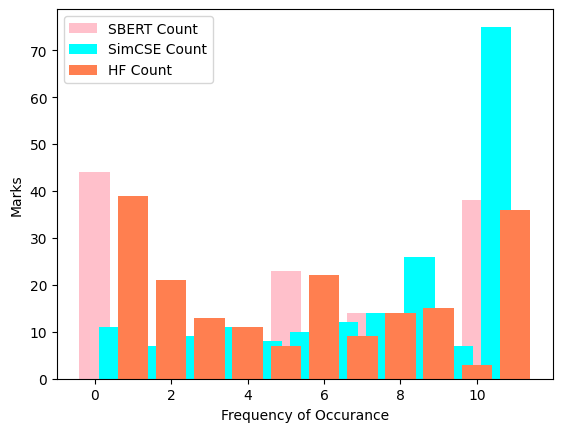

In [7]:
barWidth = 0.5

br1 = np.arange(len(sbert_freq))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.bar(br1, sbert_freq, color='pink', label='SBERT Count')
plt.bar(br2, simcse_freq, color='cyan', label='SimCSE Count')
plt.bar(br3, hf_freq, color='coral', label='HF Count')
plt.xlabel("Frequency of Occurance")
plt.ylabel("Marks")
plt.legend()
plt.show()